# Spotify Track Popularity Classification

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import mlflow.sklearn


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, classification_report, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

/Users/level3/Desktop/ml-ops-part-2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1. **Download the Dataset**

In [2]:
spotify_data = pd.read_csv("../data/spotify_data.csv")
print(spotify_data['duration_ms'].unique())

[240166 216387 158960 ... 361935 492819 325697]


* Average Popularity by Year (2000-2023)

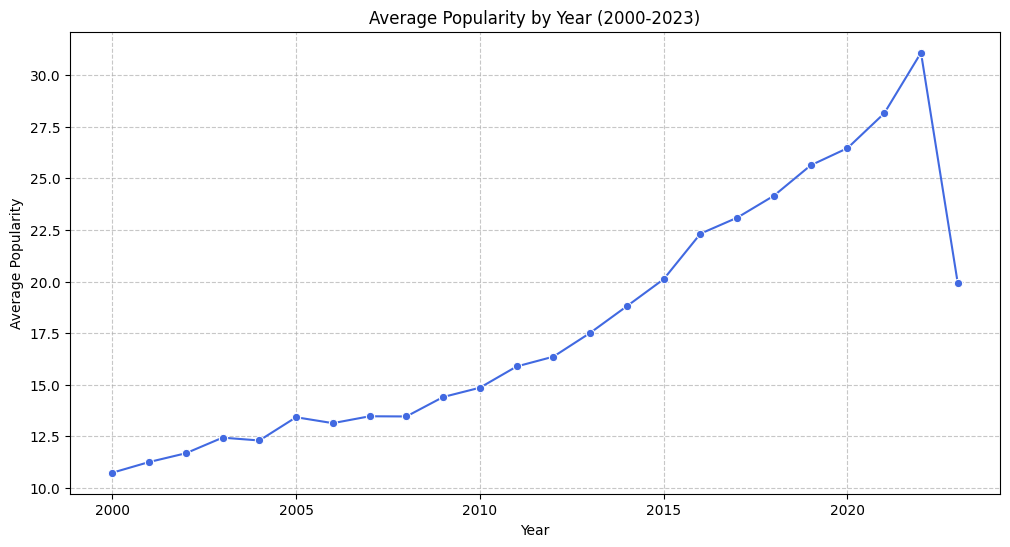

In [3]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=spotify_data,
    x='year',
    y='popularity',
    estimator='mean',
    errorbar=None,
    marker='o',
    color='royalblue'
)
plt.title("Average Popularity by Year (2000-2023)")
plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

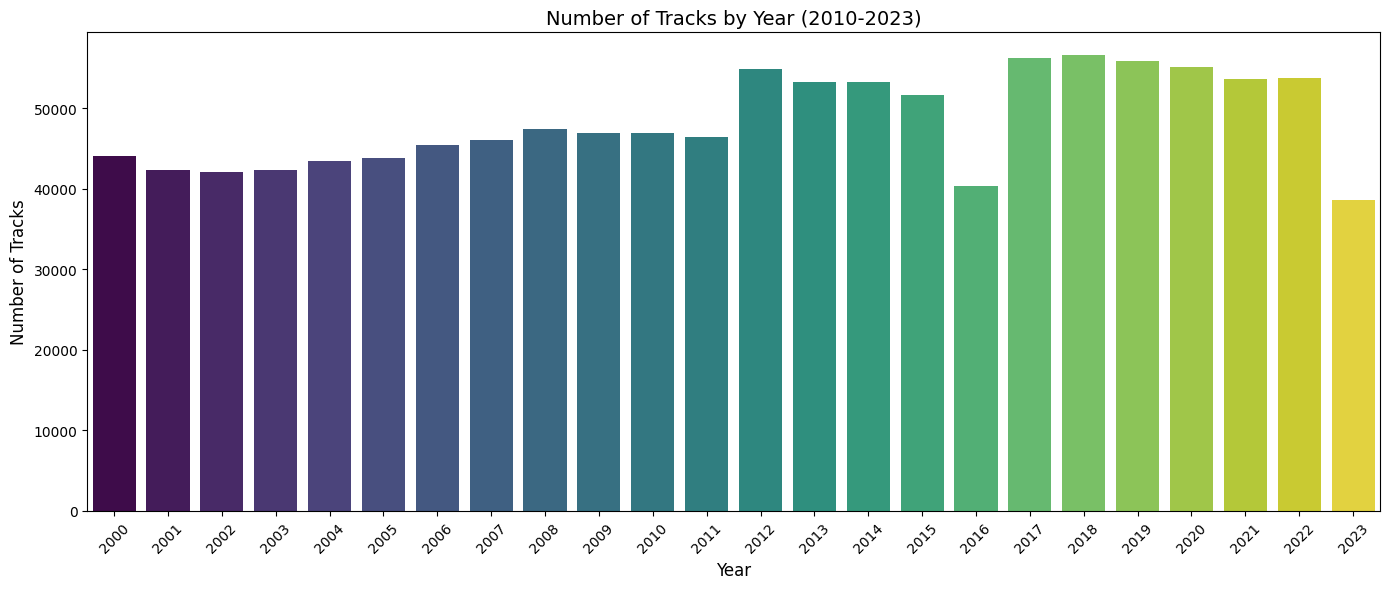

In [4]:
# Filter data for years <= 2022
spotify_data_filtered = spotify_data[spotify_data['year'] <= 2023]

# Create the plot
plt.figure(figsize=(14, 6))
sns.countplot(
    data=spotify_data_filtered,
    x='year',
    hue='year',
    palette='viridis',
    legend=False
)
plt.title("Number of Tracks by Year (2010-2023)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Tracks", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Observation of the visualization**
- A dramatic drop occurs in 2023
- This drop suggests that newer songs haven't had enough time to gain popularity

---

**popularity normalization**

- 2023 tracks haven't had sufficient time to accumulate meaningful popularity metrics
- older tracks of year 2000 - 2022 have had more time to accumulate popularity

**Check for data quality issues in 2016 and 2012**

- these years show unusual patterns in track counts that might warrant investigation


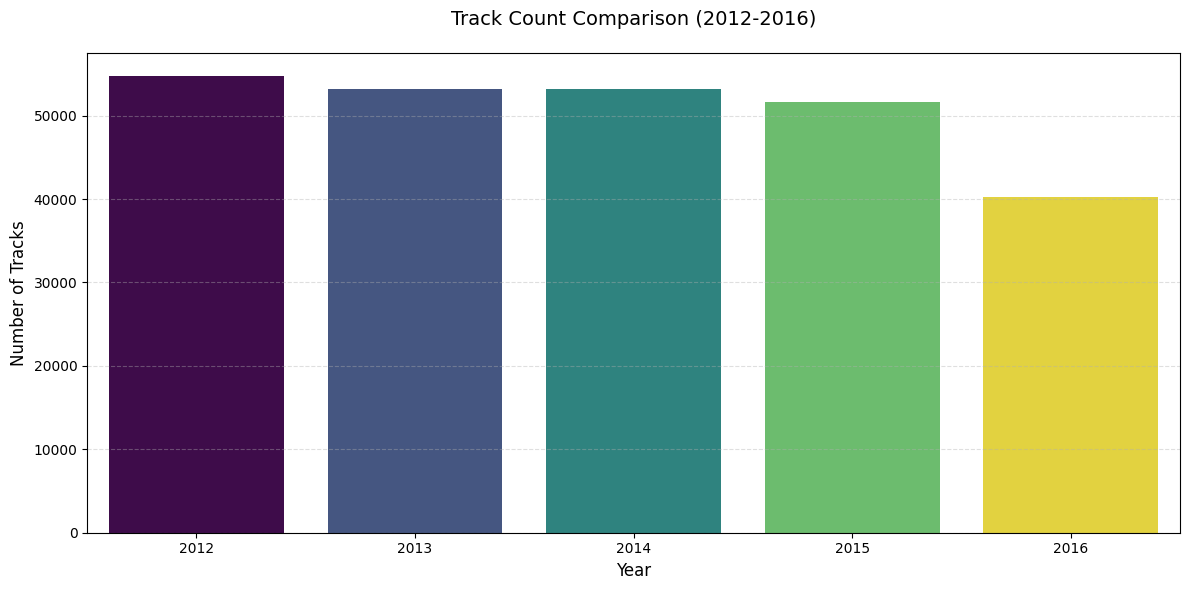

In [5]:
# Filter years 2012-2016
year_range = spotify_data_filtered[(spotify_data_filtered['year'] >= 2012) & (spotify_data_filtered['year'] <= 2016)]

# Plot with improved styling
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=year_range,
    x='year',
    hue='year',
    palette='viridis',
    legend=False,
    dodge=False
)

# Add annotations and styling
plt.title('Track Count Comparison (2012-2016)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Tracks', fontsize=12)
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Choose features that make sense for predicting popularity

In [9]:
# -------------------------------
# Define Features and Target
# -------------------------------
NUMERIC_FEATURES = [
    'instrumentalness',
    'duration_ms',
    'danceability',
    'loudness',
    'acousticness',
    'energy',
    'valence',
    'speechiness'
]

CATEGORICAL_FEATURES = ['year']
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'is_popular'

features_target = spotify_data[FEATURES + [TARGET]]
features_target.head()



,instrumentalness,duration_ms,danceability,loudness,acousticness,energy,valence,speechiness,year,is_popular
0,0.000000,240166,0.483,-10.058,0.6940,0.303,0.139,0.0429,2012,1
1,0.000014,216387,0.572,-10.286,0.4770,0.454,0.515,0.0258,2012,1
2,0.000050,158960,0.409,-13.711,0.3380,0.234,0.145,0.0323,2012,1
3,0.000000,304293,0.392,-9.845,0.8070,0.251,0.508,0.0363,2012,1
4,0.019300,244320,0.430,-5.419,0.0726,0.791,0.217,0.0302,2012,1


In [10]:
# -------------------------------
# Create binary target
# -------------------------------
spotify_data['is_popular'] = (spotify_data['popularity'] >= 50).astype(int)

# -------------------------------
# Split Data
# -------------------------------
X = spotify_data[FEATURES]
y = spotify_data[TARGET]

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

##  Build a classification Pipeline

In [11]:
# -------------------------------
# Define Preprocessing Pipeline
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), NUMERIC_FEATURES),
        ('categorical', OneHotEncoder(drop='first'), CATEGORICAL_FEATURES)
    ]
)

# -------------------------------
# Define Full Pipeline
# -------------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

# -------------------------------
# Train & Evaluate
# -------------------------------
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.7236851635332706
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83    276693
           1       0.11      0.72      0.19     13248

    accuracy                           0.72    289941
   macro avg       0.55      0.72      0.51    289941
weighted avg       0.94      0.72      0.80    289941



In [12]:
# -------------------------------
# Full Pipeline with Random Forest
# -------------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        max_depth=10,
        random_state=RANDOM_STATE
    ))
])

# -------------------------------
# Train & Evaluate
# -------------------------------
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6981178929506348
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81    276693
           1       0.11      0.77      0.19     13248

    accuracy                           0.70    289941
   macro avg       0.55      0.73      0.50    289941
weighted avg       0.94      0.70      0.79    289941



## Evaluation to MLflow


In [24]:
# -------------------------------
# Pipeline with XGBoost
# -------------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),  # to handle imbalance
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    ))
])

# -------------------------------
# Train & Evaluate
# -------------------------------
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/Users/level3/Desktop/ml-ops-part-2/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:04:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7427131726799591
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85    276693
           1       0.12      0.77      0.21     13248

    accuracy                           0.74    289941
   macro avg       0.56      0.76      0.53    289941
weighted avg       0.95      0.74      0.82    289941



In [13]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Spotify Track Popularity Song")

<Experiment: artifact_location='mlflow-artifacts:/926672945749268383', creation_time=1747232458536, experiment_id='926672945749268383', last_update_time=1747232458536, lifecycle_stage='active', name='Spotify Track Popularity Song', tags={}>

In [25]:
with mlflow.start_run():
    mlflow.log_params({
        "model_type": "XGBClassifier",
        "class_weight": "balanced",
        "features": ', '.join(features + categorical_features)
    })

    # Train model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate and log metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    mlflow.sklearn.log_model(pipeline, "model")
    print("✅ Logged Random Forest model to MLflow.")

/Users/level3/Desktop/ml-ops-part-2/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:05:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/05/18 13:05:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/18 13:05:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged Random Forest model to MLflow.
